<a href="https://colab.research.google.com/github/VitorFRodrigues/Data-Science-Bootcamp/blob/main/Modulo05/Bootcamp_Datascience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Módulo 05

##Workflow de Machine Learning

In [1]:
import pandas as pd
import numpy as np

# dados = pd.read_excel("https://github.com/VitorFRodrigues/Data-Science-Bootcamp/blob/main/Modulo05/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
# dados.head()

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [2]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [3]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [4]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_categorizar = dados_limpos.AGE_PERCENTIL
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)


x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.5340909090909091

In [6]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

In [7]:
for coluna in dados.columns:
    if coluna not in x_columns:
        print(coluna)

###Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categoricos, mas utilizando outro metodo

###Desafio 02: Verificar o impacto da mudança nos resultados

In [8]:
#https://pbpython.com/categorical-encoding.html
dados_categorizar

PATIENT_VISIT_IDENTIFIER      
0                         0             60th
2                         10            10th
3                         15            40th
4                         20            10th
5                         25            10th
                                     ...    
380                       1900          40th
381                       1905    Above 90th
382                       1910          50th
383                       1915          40th
384                       1920          50th
Name: AGE_PERCENTIL, Length: 352, dtype: object

In [9]:
# Metodologia Find and Replace
dados_categorizar.unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

In [10]:
dados_categorizar.value_counts()

20th          42
30th          39
40th          38
10th          37
80th          36
70th          34
50th          34
Above 90th    34
60th          30
90th          28
Name: AGE_PERCENTIL, dtype: int64

In [11]:
substituir = {"60th": 60, 
              "10th": 10, 
              "40th": 40, 
              "70th": 70, 
              "20th": 20, 
              "50th": 50, 
              "80th": 80, 
              "30th": 30,
              "90th": 90, 
              "Above 90th": 100}
dados_categorizado_find_replace = dados_categorizar.replace(substituir)
dados_categorizado_find_replace

PATIENT_VISIT_IDENTIFIER      
0                         0        60
2                         10       10
3                         15       40
4                         20       10
5                         25       10
                                 ... 
380                       1900     40
381                       1905    100
382                       1910     50
383                       1915     40
384                       1920     50
Name: AGE_PERCENTIL, Length: 352, dtype: int64

In [12]:
# Metodologia Label Encoding
dados_categorizado_label_enc = dados_categorizar.astype('category').cat.codes
dados_categorizado_label_enc

PATIENT_VISIT_IDENTIFIER      
0                         0       5
2                         10      0
3                         15      3
4                         20      0
5                         25      0
                                 ..
380                       1900    3
381                       1905    9
382                       1910    4
383                       1915    3
384                       1920    4
Length: 352, dtype: int8

In [13]:
# Metodologia One Hot Encoding
pd.get_dummies(dados_categorizar).head()

,,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,0,0
2,10,1,0,0,0,0,0,0,0,0,0
3,15,0,0,0,1,0,0,0,0,0,0
4,20,1,0,0,0,0,0,0,0,0,0
5,25,1,0,0,0,0,0,0,0,0,0


In [14]:
# Metodologia Scikit-Learn - OriginalEncoder
from sklearn.preprocessing import OrdinalEncoder

dados_categorizar_code = pd.DataFrame([dados_categorizar]).T
dados_categorizar_code = dados_categorizar_code.reset_index().drop('level_1', axis=1).drop('PATIENT_VISIT_IDENTIFIER', axis=1)

ord_enc = OrdinalEncoder()
dados_categorizar_code["AGE_PERCENTIL_code"] = ord_enc.fit_transform(dados_categorizar_code[["AGE_PERCENTIL"]])
dados_categorizar_code

,AGE_PERCENTIL,AGE_PERCENTIL_code
0,60th,5.0
1,10th,0.0
2,40th,3.0
3,10th,0.0
4,10th,0.0
...,...,...
347,40th,3.0
348,Above 90th,9.0
349,50th,4.0
350,40th,3.0


In [15]:
# Metodologia Scikit-Learn - OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

dados_categorizar_code = pd.DataFrame([dados_categorizar]).T
dados_categorizar_code = dados_categorizar_code.reset_index().drop('level_1', axis=1).drop('PATIENT_VISIT_IDENTIFIER', axis=1)

oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(dados_categorizar_code)
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Métricas da Avaliação

In [16]:
dados_limpos.AGE_PERCENTIL.value_counts()

1    42
2    39
3    38
0    37
7    36
6    34
4    34
9    34
5    30
8    28
Name: AGE_PERCENTIL, dtype: int64

In [17]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)

accuracy_score(y_test, predicao_arvore)

0.6477272727272727

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


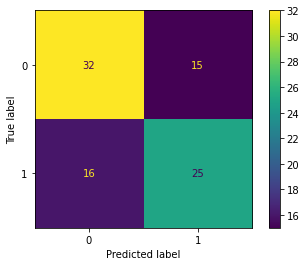

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

In [19]:
# O que a acuracia calcula são os acertos
(25+32)/(25+32+15+16)

0.6477272727272727

In [20]:
# Verdadeiro Positivo - Previ 1 e Verdade 1
VP = 25
# Verdadeiro Negativo - Previ 0 e Verdade 0
VN = 32
# Falso Positivo - Previ 1 e Verdade 0
FP = 15
# Falso Negativo - Previ 0 e Verdade 1
FN = 16

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67        47
           1       0.62      0.61      0.62        41

    accuracy                           0.65        88
   macro avg       0.65      0.65      0.65        88
weighted avg       0.65      0.65      0.65        88



In [22]:
 # Precisão = todas as minhas classificações positias, quantas são realmente positivas
 # Recall = de todas as classes positivas, quantas eu realmente classifiquei corretamente

In [23]:
VP/(VP+FP)

0.625

In [24]:
p = 1.0 #precisão
r = 0.005 #recall
f1 = 2*(p * r) / (p+r)
print(f1)

0.009950248756218907


###Desafio 03: Pesquisar sobre o F-Score
###Desafio 04: Pesquisar e plotar a árvore de decisão criada pelo modelo


In [25]:
from sklearn.metrics import roc_auc_score

prob_arvore = modelo_arvore.predict_proba(x_test)
roc_auc_score(y_test, prob_arvore[:,1])

0.6453035806953815

In [26]:
def roda_modelo(modelo, dados):

  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predic[:,1])
  print(f"AUC {auc}")
  print("\nClassification Report")
  print(classification_report(y_test, predicao))

In [27]:
roda_modelo(modelo_arvore, dados_limpos)

AUC 0.7000518941359627

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.77      0.73        47
           1       0.70      0.63      0.67        41

    accuracy                           0.70        88
   macro avg       0.70      0.70      0.70        88
weighted avg       0.70      0.70      0.70        88



###Desafio 05: Criar uma função que gere a curva ROC de vários modelos em uma única curva

###Desafio 06: Como reduzir o efeito de aleatoriedade nas previsões e conseguir comparar qual melhor modelo



##Aleatoriedade de Modelos

In [28]:
import numpy as np
def roda_n_modelo(modelo, dados, n):

  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  auc_lista = []
  for _ in range(n):
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
    modelo.fit(x_train, y_train)
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    auc_lista.append(auc)

  auc_media = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  print(f"AUC {auc_media}")
  print(f"Intervalo [{auc_media - 2*auc_std},{auc_media + 2*auc_std}]")
  print(f"Diferença: {4*auc_std}")

In [29]:
#AOC de Arvore de Classificação
roda_n_modelo(modelo_arvore, dados_limpos, 50)

AUC 0.6286455630513752
Intervalo [0.5332835116593849,0.7240076144433655]
Diferença: 0.1907241027839806


In [30]:
#AOC de Arvore de Classificação
roda_n_modelo(modelo_arvore, dados_limpos, 50)

AUC 0.6285262065386611
Intervalo [0.555105733754702,0.7019466793226202]
Diferença: 0.1468409455679183


In [31]:
#AOC de regreção logistica
roda_n_modelo(modelo, dados_limpos, 50)

AUC 0.7547586922677739
Intervalo [0.6737569919860754,0.8357603925494724]
Diferença: 0.16200340056339693


In [32]:
#AOC de regreção logistica
roda_n_modelo(modelo, dados_limpos, 50)

AUC 0.7635288012454592
Intervalo [0.6767356293970513,0.850321973093867]
Diferença: 0.17358634369681575


###Desafio 07: Estudar a documentação do skLearn e testar outros modelos

##Validação cruzada

In [33]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5, shuffle= True)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.58882213, 0.45424247, 0.6245532 , 0.6718986 , 0.446522  ]),
 'score_time': array([0.00564456, 0.00702953, 0.00553846, 0.00549579, 0.00540018]),
 'test_score': array([0.77464789, 0.64788732, 0.71428571, 0.77142857, 0.72857143])}

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.54836917, 0.5259428 , 0.16683698, 0.57463145, 0.46440172,
        0.48544717, 0.66351032, 0.14411783, 0.15577674, 0.58425665,
        0.57227564, 0.24374175, 0.52330756, 0.23587704, 0.20054293,
        0.51352382, 0.19796085, 0.49565387, 0.46921897, 0.61943388,
        0.50402808, 0.48766446, 0.46948671, 0.46402001, 0.53662634,
        0.25101376, 0.48618889, 0.23583722, 0.20395374, 0.44342399,
        0.62413192, 0.55379272, 0.55670261, 0.59926224, 0.23446226,
        0.1902566 , 0.23154044, 0.54433203, 0.57471752, 0.21149135,
        0.21865201, 0.60917997, 0.47391462, 0.44649196, 0.21296549,
        0.21547437, 0.59336948, 0.18191171, 0.14476371, 0.54264259]),
 'score_time': array([0.00534415, 0.00557065, 0.00551748, 0.00557947, 0.00572705,
        0.00547791, 0.00545287, 0.00608206, 0.00547552, 0.00554061,
        0.00559616, 0.00549483, 0.00549054, 0.00550508, 0.00543475,
        0.0056715 , 0.00567126, 0.00536942, 0.00556946, 0.00553584,
        0.00540853, 

In [35]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True) #pega todos os dados e embaralha
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')
  
  auc_medio = np.mean(resultados['test_score'])
  auc_std = np.std(resultados['test_score'])

  print(f"AUC Médio (teste) {auc_medio}")
  print(f"Intervalo médio [{auc_medio - 2*auc_std},{auc_medio + 2*auc_std}]")
  print(f"Diferença médio: {4*auc_std}")

In [36]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio (teste) 0.7567775281262124
Intervalo médio [0.6340148745409584,0.8795401817114663]
Diferença médio: 0.24552530717050797


In [37]:
roda_n_modelo(modelo, dados_limpos, 50)

AUC 0.7610586403736377
Intervalo [0.6546991740641374,0.867418106683138]
Diferença: 0.21271893261900068


###Desafio 08: Testar outros splitter classes e observar as diferenças

##Desafios em Machine Learning

In [38]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio (teste) 0.6279279683391525
Intervalo médio [0.4988394445682657,0.7570164921100394]
Diferença médio: 0.25817704754177373


In [39]:
roda_n_modelo(modelo_arvore, dados_limpos, 50)

AUC 0.6369745718733784
Intervalo [0.5260955518751533,0.7478535918716034]
Diferença: 0.22175803999645


In [40]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True) #pega todos os dados e embaralha
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
  
  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])

  print(f"AUC Teste: {auc_medio} / AUC Treino: {auc_medio_treino}")
  # print(f"Intervalo médio [{auc_medio - 2*auc_std},{auc_medio + 2*auc_std}]")
  # print(f"Diferença médio: {4*auc_std}")
  return auc_medio, auc_medio_treino

In [41]:
from sklearn.tree import DecisionTreeClassifier

pltTest = []
pltTreino = []
for i in range(1, 15):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  pltTest.append(teste)
  pltTreino.append(treino)


AUC Teste: 0.5755830262080263 / AUC Treino: 0.6445982993536308
AUC Teste: 0.6544700741411268 / AUC Treino: 0.75415524801741
AUC Teste: 0.6643847795163584 / AUC Treino: 0.8243714304989842
AUC Teste: 0.6554932930837536 / AUC Treino: 0.8832038893699776
AUC Teste: 0.6475058192163456 / AUC Treino: 0.9275331115338461
AUC Teste: 0.6239047951959137 / AUC Treino: 0.9567921210944048
AUC Teste: 0.6117738776455882 / AUC Treino: 0.9745102329260463
AUC Teste: 0.5987671815056683 / AUC Treino: 0.9855938255169409
AUC Teste: 0.5877544694814432 / AUC Treino: 0.991376822665679
AUC Teste: 0.5917582923832925 / AUC Treino: 0.9946888385564852
AUC Teste: 0.6009579413444545 / AUC Treino: 0.9970452758822465
AUC Teste: 0.6147261533363507 / AUC Treino: 0.9986297665919551
AUC Teste: 0.6212348996723998 / AUC Treino: 0.9994661199548005
AUC Teste: 0.6256292095025647 / AUC Treino: 0.9998695491440995


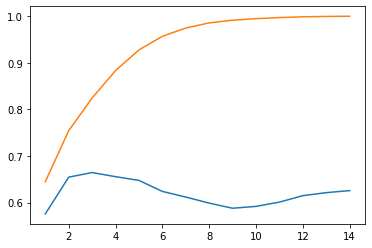

In [42]:
import matplotlib.pyplot as plt
x = range(1,15)
plt.plot(x, pltTest)
plt.plot(x, pltTreino)


###Desafio 09: Deixar o gráfico de AUC bonitão
###Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic)
###Desafio 11: Estudar um pouco mais sobre Overfit e Underfit

AUC Teste: 0.7754785968683994 / AUC Treino: 0.8549995635150238
AUC Teste: 0.7868632672744513 / AUC Treino: 0.8976687127896622
AUC Teste: 0.7931550390103022 / AUC Treino: 0.9403124842531797
AUC Teste: 0.7983565832578993 / AUC Treino: 0.9709123570096604
AUC Teste: 0.7990938591103065 / AUC Treino: 0.98788117359786
AUC Teste: 0.8004527808310704 / AUC Treino: 0.9959760554693325
AUC Teste: 0.7994808369972844 / AUC Treino: 0.9990287365273224
AUC Teste: 0.7977776116427432 / AUC Treino: 0.9998630161707951
AUC Teste: 0.7963008103797579 / AUC Treino: 0.9999847540078024
AUC Teste: 0.7927381904931247 / AUC Treino: 1.0
AUC Teste: 0.7928442699577567 / AUC Treino: 1.0
AUC Teste: 0.7923345025647657 / AUC Treino: 1.0
AUC Teste: 0.7939161507500323 / AUC Treino: 1.0
AUC Teste: 0.7939437314108367 / AUC Treino: 1.0


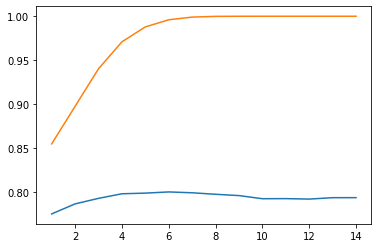

In [43]:
from sklearn.ensemble import RandomForestClassifier

pltTest = []
pltTreino = []
for i in range(1, 15):
  modelo_arvore = RandomForestClassifier(max_depth=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  pltTest.append(teste)
  pltTreino.append(treino)

import matplotlib.pyplot as plt
x = range(1,15)
plt.plot(x, pltTest)
plt.plot(x, pltTreino)

AUC Teste: 0.7810829063213933 / AUC Treino: 1.0
AUC Teste: 0.7939557739557739 / AUC Treino: 1.0
AUC Teste: 0.7920042957131773 / AUC Treino: 1.0
AUC Teste: 0.7950421219664641 / AUC Treino: 1.0
AUC Teste: 0.7969177416052416 / AUC Treino: 1.0
AUC Teste: 0.7989840011961724 / AUC Treino: 1.0
AUC Teste: 0.7947529931247036 / AUC Treino: 1.0
AUC Teste: 0.7987545193219535 / AUC Treino: 1.0
AUC Teste: 0.7917828624078624 / AUC Treino: 1.0
AUC Teste: 0.798442632225527 / AUC Treino: 1.0
AUC Teste: 0.7994379539527565 / AUC Treino: 1.0
AUC Teste: 0.793567294118281 / AUC Treino: 1.0
AUC Teste: 0.7988139911741885 / AUC Treino: 1.0
AUC Teste: 0.7922058601663865 / AUC Treino: 1.0
AUC Teste: 0.7995034672830725 / AUC Treino: 1.0
AUC Teste: 0.798531880415104 / AUC Treino: 1.0
AUC Teste: 0.7965426311478945 / AUC Treino: 1.0
AUC Teste: 0.7951840798633562 / AUC Treino: 1.0
AUC Teste: 0.8022503327190827 / AUC Treino: 1.0


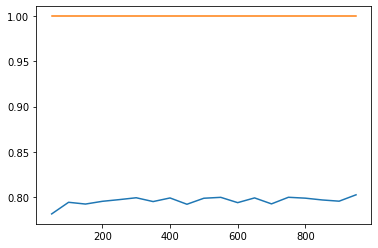

In [44]:
pltTest = []
pltTreino = []
for i in range(50, 500, 50):
  modelo_arvore = RandomForestClassifier(n_estimators=i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  pltTest.append(teste)
  pltTreino.append(treino)

import matplotlib.pyplot as plt
x = range(50, 500, 50)
plt.plot(x, pltTest)
plt.plot(x, pltTreino)

###Desafio 12: Escolha um modelo de ML, estude os hiperparametros desse modelo, teste vários hiperparametros.

###Desafio 13: Pesquisar como salvar um modelo treinado. No momento de salvar, aplique todos os dados como treino.

##Finalizando a validação

In [45]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 664.1+ KB


In [46]:
dados_limpos.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


In [47]:
# Matriz de correlação dos dados do tipo float, absolutos
alta_corr = 0.95
matrix_corr = dados_limpos.iloc[:,4:-2].corr().abs()
matrix_corr

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,0.009174,0.009174,0.009174,0.009174,NaN,0.030413,0.030413,0.030413,0.030413,NaN,0.104179,0.104179,0.104179,0.104179,NaN,0.013215,0.013215,0.013215,0.013215,NaN,0.072771,0.072771,0.072771,0.072771,NaN,0.046671,0.046671,0.046671,0.046671,NaN,0.020510,...,0.005561,0.005561,0.005561,NaN,0.105965,0.112316,0.015686,0.089330,0.035513,0.025573,0.100418,0.110268,0.033409,0.092466,0.033773,0.031653,0.084358,0.124403,0.021311,0.094510,0.024580,0.037813,0.120437,0.099909,0.032427,0.073348,0.042184,0.008804,0.054710,0.053091,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,0.196347,1.000000,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,0.032245,0.032245,0.032245,0.032245,NaN,0.013532,0.013532,0.013532,0.013532,NaN,0.027544,0.027544,0.027544,0.027544,NaN,0.005880,0.005880,0.005880,0.005880,NaN,0.036119,0.036119,0.036119,0.036119,NaN,0.003539,0.003539,0.003539,0.003539,NaN,0.009126,...,0.048981,0.048981,0.048981,NaN,0.095532,0.031352,0.016813,0.020068,0.011225,0.032448,0.112696,0.024483,0.012664,0.021007,0.012416,0.059772,0.093647,0.026938,0.021756,0.019150,0.005121,0.038081,0.070772,0.041188,0.015483,0.018921,0.016164,0.006302,0.046677,0.029821,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,0.278271,0.084392,1.000000,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,0.035719,0.035719,0.035719,0.035719,NaN,0.028061,0.028061,0.028061,0.028061,NaN,0.078813,0.078813,0.078813,0.078813,NaN,0.121935,0.121935,0.121935,0.121935,NaN,0.058743,0.058743,0.058743,0.058743,NaN,0.006233,0.006233,0.006233,0.006233,NaN,0.165258,...,0.009263,0.009263,0.009263,NaN,0.046600,0.144381,0.050511,0.052495,0.095023,0.149534,0.055008,0.141602,0.047499,0.043561,0.093179,0.149762,0.039784,0.136814,0.048458,0.060394,0.093307,0.139419,0.044819,0.150604,0.053770,0.049369,0.088511,0.140484,0.005354,0.027667,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,0.017529,0.114818,0.308875,1.000000,0.128287,0.171438,0.136472,0.103100,0.063919,0.049593,0.049593,0.049593,0.049593,NaN,0.012640,0.012640,0.012640,0.012640,NaN,0.051789,0.051789,0.051789,0.051789,NaN,0.005492,0.005492,0.005492,0.005492,NaN,0.072546,0.072546,0.072546,0.072546,NaN,0.028718,0.028718,0.028718,0.028718,NaN,0.008524,...,0.033033,0.0

In [48]:
matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(bool))
excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)]
len(excluir)

131

In [49]:
def remove_corr_var(dados, valor_corte):
  
  matrix_corr = dados.iloc[:,4:-2].corr().abs()
  matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(bool))
  excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]
  
  return dados.drop(excluir, axis=1)

In [50]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

In [51]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Teste: 0.8022503327190827 / AUC Treino: 1.0


(0.8022503327190827, 1.0)

In [52]:
roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC Teste: 0.8095855088042587 / AUC Treino: 1.0


(0.8095855088042587, 1.0)

###Desafio 14: Ler no Sklearn sobre feature selection, feature importance

###Desafio 15: Plotar também a matriz de confusão para item filtrado

###Desafio 16: Repassar pelo desafio 12, com as bases de dados alteradas 

###Desafio 17: Como fazer um pipeline de treinamento 